# ID2214 Programming for Data Science

### Assignment 4

Authors: \
Lucas Larsson lulars@kth.se \
Mihaela Bakšić baksic@kth.se

In [ ]:
! pip install rdkit
! pip install molmass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Defining input and output file paths
TRAIN_DATASET_PATH = '/content/gdrive/My Drive/ID2214/training_smiles.csv'
TEST_DATASET_PATH = '/content/gdrive/My Drive/ID2214/test_smiles.csv'
FEATURES_OPTIM_RES_PATH = '/content/gdrive/My Drive/ID2214/features_optim.csv'
FINGERPRINT_OPTIM_RES_PATH = '/content/gdrive/My Drive/ID2214/fingerprint_size_opt.csv'
TRAIN_DATASET_PREPARED_PATH = '/content/gdrive/My Drive/ID2214/training_prepared.csv'
TEST_DATASET_PREPARED_PATH = '/content/gdrive/My Drive/ID2214/test_prepared.csv'

CUSTOM_RES_PATH = '/content/gdrive/My Drive/ID2214/custom_res.csv'
FP_RES_PATH = '/content/gdrive/My Drive/ID2214/fp_res.csv'
COMBINED_RES_PATH =  '/content/gdrive/My Drive/ID2214/combined_res.csv'

RESULT_PATH = '/content/gdrive/My Drive/ID2214/4.csv'


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures, AllChem, Draw, rdmolops, Lipinski, rdMolDescriptors, Fragments,Crippen
from rdkit import RDConfig
from molmass import Formula
import os
import re

ModuleNotFoundError: ignored

## Data import and feature extraction

In [ ]:
train_data = pd.read_csv(TRAIN_DATASET_PATH, dtype = {'ACTIVE': int})

train_data.head()

,INDEX,SMILES,ACTIVE
0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0
1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0
2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0
3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0
4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0


In [ ]:
train_data[['INDEX', 'ACTIVE']].groupby('ACTIVE').count()

,INDEX
ACTIVE,
0,154528
1,1730


### Feature extracting functions

In [ ]:
def extract_charge(df):
  '''
    Extracts molecule charge from the mol column of the dataframe
    Returns charge series
  '''
  return df['MOL'].apply(lambda x: rdmolops.GetFormalCharge(x))


def extract_mol(df):
  '''
    Extracts molecule object from the smiles column of the dataframe
    Returns molecule series
  '''
  return df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))


def extract_num_atoms(df, atom_symbol):
  '''
    Extracts number of atoms with a given symbol from the molecule
    Returns count series
  '''

  m = Chem.MolFromSmarts(atom_symbol)
  return df['MOL'].apply(lambda x: len(x.GetSubstructMatches(m)))


def extract_fingerprints(df, size_fp=124):
  '''
    Extracts fingerprint vectors from smiles columns
    Returns a dataframe where each column is a fingerprint bit and a list of fingerprint feature names
  '''

  fingerprints = df['MOL'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=size_fp))
  fp_features = [f'fp_{i}' for i in range(size_fp)]

  fingerprints_array = [ [ fp[i] for i in range(size_fp) ] for fp in fingerprints]
  return pd.DataFrame(data=fingerprints_array, columns=fp_features), fp_features


def extract_heavy_atom_count(df):
  '''
  Extracts number of heavy atoms from the molecule
  Returns a series with the heavy atom count
  '''
  return df['MOL'].apply(lambda x: Lipinski.HeavyAtomCount(x))

def extract_NHOH(df):

  return df['MOL'].apply(lambda x: Lipinski.NHOHCount(x))

def extract_num_rings(df):
  return df['MOL'].apply(lambda x: Lipinski.RingCount(x))
  
def extract_num_aromatic_rings(df):
  return df['MOL'].apply(lambda x: Lipinski.NumAromaticRings(x))

def extract_num_saturated_rings(df):
  return df['MOL'].apply(lambda x: Lipinski.NumSaturatedRings(x))


def extract_donors_and_acceptors(df):
  '''
  Extracts number of hydrogen Acceptors and Donors respectivlly 
  Returns two seriess containing the number bondes of 'Acceptors' and 'Donors'
  '''
  acceptors = df['MOL'].apply(lambda x: Lipinski.NumHAcceptors(x))
  donors = df['MOL'].apply(lambda x: Lipinski.NumHDonors(x))
  return acceptors, donors
  

def calculate_mass(df):
  '''
  Calculates the mass of a molecule
  Returns a series with mass of molecule in dalton
  '''
  return df['MOL'].apply(lambda x: Formula(re.sub(r"-\d+","", rdMolDescriptors.CalcMolFormula(x))).mass)


def extract_Al_OOF(df):
  return df['MOL'].apply(lambda x: Fragments.fr_Al_COO(x))

def extract_Al_OH(df):
  return df['MOL'].apply(lambda x: Fragments.fr_Al_OH(x))

def extract_saturated_carbocycles(df):
  return df['MOL'].apply(lambda x: Lipinski.NumSaturatedCarbocycles(x))

def extract_saturated_heterocycles(df):
  return df['MOL'].apply(lambda x: Lipinski.NumSaturatedHeterocycles(x))


def extract_functional_groups(df):
  return df['MOL'].apply(lambda x: Fragments.fr_ArN(x))


def extract_log_p(df):
  return df['MOL'].apply(lambda x: Crippen.MolLogP(x))


def extract_mol_mr(df):
  return df['MOL'].apply(lambda x: Crippen.MolMR(x))


def calc_rotatable_bonds(df):
  return df['MOL'].apply(lambda x: rdMolDescriptors.CalcNumRotatableBonds(x))


## Applying feature extraction

Features extracted from SMILEs can be categorised in 2 groups: 
- fingerprint vector features
- custom features extracted using rdkit and molmass libraries

We use this feature groups together and separately to determine the most suitable feature set, based on model performances.

In [ ]:
train_data['MOL'] = extract_mol(train_data)
train_data['CHARGE'] = extract_charge(train_data)
train_data['NUM_C'] = extract_num_atoms(train_data, 'C')
train_data['NUM_O'] = extract_num_atoms(train_data, 'O')
train_data['NUM_N'] = extract_num_atoms(train_data, 'N')
train_data['NUM_HEAVY'] = extract_heavy_atom_count(train_data)
train_data['MASS'] = calculate_mass(train_data)
train_data['ACCEPTORS'], train_data['DONORS'] = extract_donors_and_acceptors(train_data)
train_data['AL_OOF'] = extract_Al_OOF(train_data)
train_data['AL_OH'] = extract_Al_OH(train_data)
train_data['NUM_NHOH'] = extract_NHOH(train_data)
train_data['NUM_RINGS'] = extract_num_rings(train_data)
train_data['NUM_AROM_RINGS'] = extract_num_aromatic_rings(train_data)
train_data['NUM_SAT_RINGS'] = extract_num_saturated_rings(train_data)
train_data['NUM_HETCYCLES'] = extract_saturated_heterocycles(train_data)
train_data['NUM_CARBCYCLES'] = extract_saturated_carbocycles(train_data)

train_data['ROTATABLE_BONDS'] = calc_rotatable_bonds(train_data)
train_data['LOG_P'] = extract_log_p(train_data)
train_data['FUNC_GROUP'] = extract_functional_groups(train_data)
train_data['MR'] = extract_mol_mr(train_data)


# fingerprints

size_fp = 512
fingerprints, fp_features = extract_fingerprints(train_data, size_fp)
train_data = train_data.join(fingerprints)


In [ ]:
custom_features_all = ['CHARGE','MASS', 'NUM_C', 'NUM_O', 'NUM_N', 'NUM_HEAVY', 
                   'ACCEPTORS', 'DONORS', 'AL_OOF', 'AL_OH', 'NUM_NHOH', 
                   'NUM_RINGS', 'NUM_AROM_RINGS', 'NUM_SAT_RINGS',
                   'NUM_HETCYCLES', 'NUM_CARBCYCLES',
                   'ROTATABLE_BONDS', 'LOG_P', 'FUNC_GROUP', 'MR'] 


In [ ]:
train_data.head()

,INDEX,SMILES,ACTIVE,MOL,CHARGE,NUM_C,NUM_O,NUM_N,NUM_HEAVY,MASS,...,NUM_CARBCYCLES,ROTATABLE_BONDS,LOG_P,FUNC_GROUP,MR,fp_0,fp_1,fp_2,fp_3,fp_4
0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0,<rdkit.Chem.rdchem.Mol object at 0x7f17ee165c10>,0,7,1,2,19,256.303633,...,0,2,1.4833,0,74.0501,1,1,1,1,1
1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0,<rdkit.Chem.rdchem.Mol object at 0x7f17ee165ba0>,0,4,4,1,30,420.481666,...,0,6,4.8023,1,118.9989,1,1,1,1,1
2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f17ee165b30>,0,7,4,0,27,364.395386,...,0,7,2.8442,0,101.7942,1,1,1,1,1
3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f17ee165ac0>,0,12,4,3,26,381.490256,...,0,5,1.5220,0,99.5575,1,1,1,1,1
4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0,<rdkit.Chem.rdchem.Mol object at 0x7f17ee165a50>,0,6,2,1,21,283.365594,...,0,7,4.4331,0,87.1657,1,1,1,1,1


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import numpy as np
import matplotlib.pyplot as plt

## Fingerprint length optimization

In [ ]:
fp_sizes = [128, 512, 1024]

n_estimators = [40, 60, 80, 100]

fp_results = []

n_runs = 30

for fp_s in fp_sizes:

  fingerprints_optim, fingerprint_features = extract_fingerprints(train_data, fp_s)

  acc_nb = 0
  f1_nb = 0
  auc_nb = 0

  acc_lr = 0
  f1_lr = 0
  auc_lr = 0

  for i in range(n_runs): # run n_runs times and average the results
    # create a train test split for current iteration
    X_train, X_validation, y_train, y_validation = train_test_split(fingerprints_optim, train_data['ACTIVE'], test_size=0.3, random_state=i)

    # fit and predict
    nb = make_pipeline(StandardScaler(),GaussianNB())
    nb.fit(X_train, y_train)
    y_valid_nb = nb.predict(X_validation)

    lr = make_pipeline(StandardScaler(),LogisticRegression())
    lr.fit(X_train, y_train)
    y_valid_lr = lr.predict(X_validation)

    # store scores
    acc_nb += accuracy_score(y_validation, y_valid_nb)
    f1_nb += f1_score(y_validation, y_valid_nb)
    auc_nb += roc_auc_score(y_validation, y_valid_nb)

    acc_lr += accuracy_score(y_validation, y_valid_lr)
    f1_lr += f1_score(y_validation, y_valid_lr)
    auc_lr += roc_auc_score(y_validation, y_valid_lr)

  acc_nb /= n_runs
  f1_nb /= n_runs
  auc_nb /= n_runs

  acc_lr /= n_runs
  f1_lr /= n_runs
  auc_lr /= n_runs




  # store results for current fp size in the dataframe
  fp_results.append([fp_s, 'nb', acc_nb, f1_nb, auc_nb])
  fp_results.append([fp_s, 'lr', acc_lr, f1_lr, auc_lr])


  for n in n_estimators:

    acc_rfc = 0
    f1_rfc = 0
    auc_rfc = 0

    for i in range(n_runs): # run 50 times and average the results
      # create a train test split for current iteration
      X_train, X_validation, y_train, y_validation = train_test_split(fingerprints_optim, train_data['ACTIVE'], test_size=0.3, random_state=i)

      rfc = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n))
      rfc.fit(X_train, y_train)
      y_valid_rfc = rfc.predict(X_validation)

      acc_rfc += accuracy_score(y_validation, y_valid_rfc)
      f1_rfc += f1_score(y_validation, y_valid_rfc)
      auc_rfc += roc_auc_score(y_validation, y_valid_rfc)

    acc_rfc /= n_runs
    f1_rfc /= n_runs
    auc_rfc /= n_runs

    fp_results.append([fp_s, f'rfc_{n}', acc_rfc, f1_rfc, auc_rfc])



rez = pd.DataFrame(data=fp_results, columns=['fp_size', 'classifier', 'acc', 'f1', 'auc'])


KeyboardInterrupt: ignored

In [ ]:
#rez.to_csv(FINGERPRINT_OPTIM_RES_PATH)

In [ ]:
fp_size_rez = pd.read_csv(FINGERPRINT_OPTIM_RES_PATH)

fp_size_rez.sort_values('auc', ascending=False).head(10)


FileNotFoundError: ignored

In [ ]:
# Train and validation split

seed = 10
X_train, X_validation, y_train, y_validation = train_test_split(train_data.drop(['INDEX', 'SMILES', 'MOL', 'ACTIVE'], axis=1), train_data['ACTIVE'], test_size=0.3, random_state=seed)

## Custom feature selection

In order to determine the quality of custom extracted features we perform feature selection

For this we use Random Forest Classifier

In [ ]:
X, y = train_data[custom_features_all], train_data['ACTIVE']

rfc = RandomForestClassifier()

rfc.fit(X, y)

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)


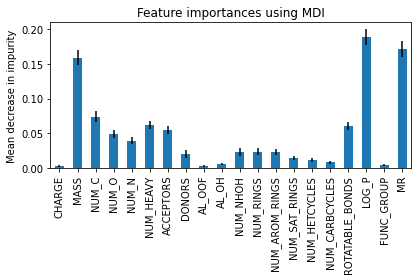

In [ ]:

forest_importances = pd.Series(importances, index=custom_features_all)


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Determining model performance with different subsets of custom featureset

The feature set is defined with regards to the threshold on mean decrease in impurity

In [ ]:
def train_validate_model(classifier, classifier_name, X, y,storage, print_rez=True):

  pipe = make_pipeline(StandardScaler(), classifier)

  # perform cross validation
  y_train = []
  y_pred = []

  cv = StratifiedKFold(n_splits=6)
  for fold, (train, valid) in enumerate(cv.split(X, y)):

    pipe.fit(X.loc[train], y.loc[train])

    y_train.extend(y.loc[valid].tolist())
    y_pred.extend(pipe.predict(X.loc[valid]))

  acc= accuracy_score(y_train, y_pred)
  f1= f1_score(y_train, y_pred)

  auc = roc_auc_score(y_train, y_pred)

  if print_rez:
    print(f'{classifier_name} :')
    print(f'Accuracy: {acc}  F1: {f1}')
    print(f'AUC = {auc}')

  
  storage.append([classifier_name, acc, f1, auc])

  return acc, f1, auc


In [ ]:
thresholds = [0.01, 0.015, 0.02, 0.05, 0.1, 0.15]

res = [] # features, classifier, acc, f1, auc
n_runs = 1

y = train_data['ACTIVE']
smote = SMOTE(sampling_strategy=0.2, random_state=10)

n = 30


for t in thresholds:
  feats = forest_importances.loc[lambda x : x > t].index.tolist()   
  X = train_data[feats]

  X_smote, y_smote = smote.fit_resample(X, y)
  
  acc_smote = 0
  f1_smote = 0
  auc_smote = 0

  print(t)
  for i in range(n_runs):
    classifier = RandomForestClassifier(n_estimators=n)
    acc, f1, auc = train_validate_model(classifier, f'RFC_{n} - smote', X_smote, y_smote, [], print_rez=False)

    acc_smote += acc
    f1_smote += f1
    auc_smote += auc

  res.append(['RFC-smote', acc_smote/n_runs, f1_smote/n_runs, auc_smote/n_runs, feats])


features_optim = pd.DataFrame(data=res, columns=['classifier', 'acc', 'f1', 'auc', 'features'])


In [ ]:
#features_optim.to_csv(FEATURES_OPTIM_RES_PATH)

features_optim = pd.read_csv(FEATURES_OPTIM_RES_PATH)

custom_features = features_optim.loc[2, 'features'][1:-1].replace('\'', '').split(', ')

print(custom_features)

fp_features = [f'fp_{i}' for i in range(512)]


['MASS', 'NUM_C', 'NUM_O', 'NUM_N', 'NUM_HEAVY', 'ACCEPTORS', 'DONORS', 'NUM_NHOH', 'NUM_RINGS', 'NUM_AROM_RINGS', 'ROTATABLE_BONDS', 'LOG_P', 'MR']


# Models

- Logistic regression
- Naive Bayes
- Random Forest
- XGBoost


In [ ]:
custom_features_res = []
fingerprint_res = []
combined_res = []

In [ ]:
# storing dataset on the disc

#train_data.to_csv(TRAIN_DATASET_PREPARED_PATH)

In [ ]:
train_data = pd.read_csv(TRAIN_DATASET_PREPARED_PATH, dtype = {'ACTIVE': int})
train_data.head()

,Unnamed: 0,Unnamed: 0.1,INDEX,SMILES,ACTIVE,MOL,CHARGE,NUM_C,NUM_O,NUM_N,...,fp_502,fp_503,fp_504,fp_505,fp_506,fp_507,fp_508,fp_509,fp_510,fp_511
0,0,0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0,<rdkit.Chem.rdchem.Mol object at 0x7f7363351ac0>,0,7,1,2,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0,<rdkit.Chem.rdchem.Mol object at 0x7f7363351b30>,0,4,4,1,...,0,0,0,0,0,0,0,0,0,1
2,2,2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f7363351820>,0,7,4,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f7363351510>,0,12,4,3,...,0,0,0,0,0,0,0,0,0,0
4,4,4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0,<rdkit.Chem.rdchem.Mol object at 0x7f73633515f0>,0,6,2,1,...,0,0,0,0,0,0,0,0,0,0


### Fingerprint dataset


In [ ]:
seed = 10
X = train_data[fp_features]
y = train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.1, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)

ros = RandomOverSampler(sampling_strategy=0.1, random_state=seed)
X_ros, y_ros = ros.fit_resample(X, y)

In [ ]:
# Logistic Regression

lr = LogisticRegression()

acc, f1, auc = train_validate_model(lr, 'Logistic Regression', X, y, storage=fingerprint_res)

acc, f1, auc = train_validate_model(lr, 'Logistic Regression smote', X_smote, y_smote, storage=fingerprint_res)

acc, f1, auc = train_validate_model(lr, 'Logistic Regression ros', X_ros, y_ros, storage=fingerprint_res)


Logistic Regression :
Accuracy: 0.9888261720999885  F1: 0.0
AUC = 0.4999482294470905
Logistic Regression smote :
Accuracy: 0.9691904929991764  F1: 0.8130911167422107
AUC = 0.8647879267478975
Logistic Regression ros :
Accuracy: 0.9112072008471584  F1: 0.22998826590480076
AUC = 0.5668039674643987


In [ ]:
# Naive Bayes

nb = GaussianNB()

acc, f1, auc = train_validate_model(nb, 'Naive Bayes Classifier', X, y, storage=fingerprint_res)

acc, f1, auc = train_validate_model(nb, 'Naive Bayes Classifier smote', X_smote, y_smote, storage=fingerprint_res)

acc, f1, auc = train_validate_model(nb, 'Naive Bayes Classifier ros', X_ros, y_ros, storage=fingerprint_res)


Naive Bayes Classifier :
Accuracy: 0.7686326460085243  F1: 0.04943075750006574
AUC = 0.657253671669358
Naive Bayes Classifier smote :
Accuracy: 0.9030415342981527  F1: 0.5976809471500061
AUC = 0.8531895128365508
Naive Bayes Classifier ros :
Accuracy: 0.7274679374044005  F1: 0.30437720549590813
AUC = 0.6952631471875282


In [ ]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=50)

print('Original dataset')
acc, f1, auc = train_validate_model(rfc, 'Random Forest Classifier',X, y, storage=fingerprint_res)

print('SMOTE dataset')
acc, f1, auc = train_validate_model(rfc, 'Random Forest Classifier smote', X_smote, y_smote, storage=fingerprint_res)

print('ROS dataset')
acc, f1, auc = train_validate_model(rfc, 'Random Forest Classifier ros', X_ros, y_ros, storage=fingerprint_res)

Original dataset
Random Forest Classifier :
Accuracy: 0.9889477658743873  F1: 0.05161998901702362
AUC = 0.5134414460084006
SMOTE dataset
Random Forest Classifier smote :
Accuracy: 0.9873926344275797  F1: 0.9266623318846036
AUC = 0.937354426311245
ROS dataset
Random Forest Classifier ros :
Accuracy: 0.9987351453112131  F1: 0.9930905935662178
AUC = 0.9992752105840613


In [ ]:
# XGBoost

n_estimators =[40, 60, 80, 100]

for n in n_estimators:
  xgb = XGBClassifier(n_estimators=n, scale_pos_weight= (len(y) - sum(y)) / sum(y))

  acc, f1, auc  = train_validate_model(xgb, f'XGB Classifier_{n}', X, y, storage=fingerprint_res)

  acc, f1, auc  = train_validate_model(xgb, f'XGB Classifier_{n}_smote', X_smote, y_smote, storage=fingerprint_res)

  acc, f1, auc = train_validate_model(xgb, f'XGB Classifier_{n}_ros', X_ros, y_ros, storage=fingerprint_res)


XGB Classifier_40 :
Accuracy: 0.738682179472411  F1: 0.049134899750832496
AUC = 0.6749756783139438
XGB Classifier_40_smote :
Accuracy: 0.16193669843511002  F1: 0.177355831976254
AUC = 0.5362715828124873
XGB Classifier_40_ros :
Accuracy: 0.09219319919990587  F1: 0.16685653814797016
AUC = 0.5007086094429489
XGB Classifier_60 :
Accuracy: 0.757913194844424  F1: 0.05340073069415946
AUC = 0.6881282154600636
XGB Classifier_60_smote :
Accuracy: 0.22037298505706554  F1: 0.18740150720798612
AUC = 0.566227193349332
XGB Classifier_60_ros :
Accuracy: 0.09544064007530298  F1: 0.16735531595734887
AUC = 0.5024946935183268
XGB Classifier_80 :
Accuracy: 0.7717492864365344  F1: 0.05635516985924437
AUC = 0.6945521480589933
XGB Classifier_80_smote :
Accuracy: 0.27729144605247674  F1: 0.1983215432404918
AUC = 0.5950276549971222
XGB Classifier_80_ros :
Accuracy: 0.10278856336039534  F1: 0.16849497306610253
AUC = 0.506536032304825
XGB Classifier_100 :
Accuracy: 0.7825071356346555  F1: 0.05824812259262338
AUC 

### Custom features dataset

In [ ]:
seed = 10
X, y = train_data[custom_features], train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.1, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)

ros = RandomOverSampler(sampling_strategy=0.1, random_state=seed)
X_ros, y_ros = ros.fit_resample(X, y)

In [ ]:
# Logistic Regression

lr = LogisticRegression()

acc, f1, auc  = train_validate_model(lr, 'Logistic Regression', X, y, storage=custom_features_res)

acc, f1, auc  = train_validate_model(lr, 'Logistic Regression smote', X_smote, y_smote, storage=custom_features_res)

acc, f1, auc = train_validate_model(lr, 'Logistic Regression ros', X_ros, y_ros, storage=custom_features_res)


Logistic Regression :
Accuracy: 0.9887749747212943  F1: 0.0034090909090909094
AUC = 0.5007796892150866
Logistic Regression :
Accuracy: 0.8957790684505994  F1: 0.6356884331171768
AUC = 0.7556968210468297
Logistic Regression :
Accuracy: 0.8459874995281315  F1: 0.3288289346901366
AUC = 0.5981397517388826


In [ ]:
# Naive Bayes

nb = GaussianNB()

acc, f1, auc  = train_validate_model(nb, 'Naive Bayes Classifier', X, y, storage=custom_features_res)

acc, f1, auc  = train_validate_model(nb, 'Naive Bayes Classifier smote', X_smote, y_smote, storage=custom_features_res)

acc, f1, auc = train_validate_model(nb, 'Naive Bayes Classifier ros', X_ros, y_ros, storage=custom_features_res)


Naive Bayes Classifier :
Accuracy: 0.9447388293719362  F1: 0.08381962864721484
AUC = 0.5905415349460209
Naive Bayes Classifier smote :
Accuracy: 0.796848457394315  F1: 0.5102383088263973
AUC = 0.7320870807795512
Naive Bayes Classifier ros :
Accuracy: 0.7767873032308166  F1: 0.45740204239476684
AUC = 0.6918736200312456


In [ ]:
# Random Forest Classifier

n = 50
rfc = RandomForestClassifier(n_estimators=n)

acc, f1, auc  = train_validate_model(rfc, f'Random Forest Classifier_{n}', X, y, storage=custom_features_res)

acc, f1, auc  = train_validate_model(rfc, f'Random Forest Classifier_{n}_smote', X_smote, y_smote, storage=custom_features_res)

acc, f1, auc  = train_validate_model(rfc, f'Naive Bayes Classifier_{n}_ros', X_ros, y_ros, storage=custom_features_res)

Random Forest Classifier_50 :
Accuracy: 0.9886341819298852  F1: 0.06329113924050632
AUC = 0.5169980605494023
Random Forest Classifier_50_smote :
Accuracy: 0.977425808782687  F1: 0.9303215926493108
AUC = 0.9481443902330097
Naive Bayes Classifier_50_ros :
Accuracy: 0.9987974093068656  F1: 0.9964051392001032
AUC = 0.9992784479188237


In [ ]:
# XGBoost

n_estimators = [40, 60, 80, 100]

for n in n_estimators:
  xgb = XGBClassifier(n_estimators=n, scale_pos_weight= (len(y) - sum(y)) / sum(y))

  acc, f1, acc = train_validate_model(xgb, f'XGB Classifier_{n}', X, y, storage=custom_features_res)

  acc, f1, acc = train_validate_model(xgb, f'XGB Classifier_{n}_smote', X_smote, y_smote, storage=custom_features_res)

  acc, f1, auc = train_validate_model(xgb, f'XGB Classifier_{n}_ros', X_ros, y_ros, storage=custom_features_res)


XGB Classifier_40 :
Accuracy: 0.7502079893509452  F1: 0.06091810220383024
AUC = 0.7411030359688635
XGB Classifier_40_smote :
Accuracy: 0.28735446225860556  F1: 0.3182413818009224
AUC = 0.5716115978384383
XGB Classifier_40_ros :
Accuracy: 0.21809494534414048  F1: 0.29876429763257806
AUC = 0.5306255120518932
XGB Classifier_60 :
Accuracy: 0.7521790884306724  F1: 0.061099796334012225
AUC = 0.7403849290234698
XGB Classifier_60_smote :
Accuracy: 0.32360475212071205  F1: 0.3296168811733014
AUC = 0.5932581577609981
XGB Classifier_60_ros :
Accuracy: 0.24656344879282543  F1: 0.3065920212818756
AUC = 0.547706558852473
XGB Classifier_80 :
Accuracy: 0.7546749606420151  F1: 0.06154524089306698
AUC = 0.740789491206188
XGB Classifier_80_smote :
Accuracy: 0.35570259878230953  F1: 0.34038183364067
AUC = 0.6124003168724697
XGB Classifier_80_ros :
Accuracy: 0.2716021420135575  F1: 0.31375398200413573
AUC = 0.5626002966517174
XGB Classifier_100 :
Accuracy: 0.7565756633260378  F1: 0.06176463333415554
AUC = 

### Combined features dataset

In [ ]:
seed = 10
X, y = train_data.drop(['INDEX', 'SMILES', 'MOL', 'ACTIVE'] , axis=1), train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.1, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)

ros = RandomOverSampler(sampling_strategy=0.1, random_state=seed)
X_ros, y_ros = ros.fit_resample(X, y)

In [ ]:
# Logistic Regression

lr = LogisticRegression()

acc, f1, auc  = train_validate_model(lr, 'Logistic Regression', X, y, storage=combined_res)

acc, f1, auc  = train_validate_model(lr, 'Logistic Regression smote', X_smote, y_smote, storage=combined_res)

acc, f1, auc = train_validate_model(lr, 'Logistic Regression ros', X_ros, y_ros, storage=combined_res)


Original dataset
Logistic Regression :
Accuracy: 0.9888581704616723  F1: 0.0022922636103151865
AUC = 0.500535971107842
SMOTE dataset


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Logistic Regression :
Accuracy: 0.9823709911396569  F1: 0.945675114250104
AUC = 0.9576865098243105
ROS dataset
Logistic Regression :
Accuracy: 0.7448100020708222  F1: 0.7456379691803575
AUC = 0.744810002070822


In [ ]:
# Naive Bayes

nb = GaussianNB()

acc, f1, auc  = train_validate_model(nb, 'Naive Bayes Classifier', X, y, storage=combined_res)

acc, f1, auc  = train_validate_model(nb, 'Naive Bayes Classifier smote', X_smote, y_smote, storage=combined_res)

acc, f1, auc = train_validate_model(nb, 'Naive Bayes Classifier ros', X_ros, y_ros, storage=combined_res)


Original dataset
Naive Bayes Classifier :
Accuracy: 0.8960053245273842  F1: 0.06587721315244884
AUC = 0.6167711267247374
SMOTE dataset
Naive Bayes Classifier :
Accuracy: 0.9402263890461784  F1: 0.8301875229807575
AUC = 0.9148103581870627
ROS dataset
Logistic Regression :
Accuracy: 0.6817567042866017  F1: 0.6929294632236553
AUC = 0.6817567042866018


In [ ]:
# Random Forest Classifier

n = 50
rfc = RandomForestClassifier(n_estimators=n)

print('Original dataset')
acc, f1, auc = train_validate_model(rfc, f'Random Forest Classifier_{n}', X, y, storage=combined_res)

print('SMOTE dataset')
acc, f1, auc = train_validate_model(rfc, f'Random Forest Classifier_{n}_smote', X_smote, y_smote, storage=combined_res)

print('ROS dataset')
acc, f1, auc = train_validate_model(rfc, f'Random Forest Classifier_{n}_ros', X_ros, y_ros, storage=combined_res)

Original dataset
Random Forest Classifier :
Accuracy: 0.9890245619424285  F1: 0.04029099048684947
AUC = 0.510336675426763
SMOTE dataset
Random Forest Classifier :
Accuracy: 0.9903738816715472  F1: 0.9703157999767184
AUC = 0.9718200972281303
ROS dataset
Logistic Regression :
Accuracy: 0.9997346759163388  F1: 0.9997347462945351
AUC = 0.9997346759163388


In [ ]:
# XGBoost

n_estimators =[ 40, 60, 80, 100]

for n in n_estimators:
  xgb = XGBClassifier(n_estimators=n, scale_pos_weight= (len(y) - sum(y)) / sum(y))

  y_true, y_pred, acc = train_validate_model(xgb, f'XGB Classifier_{n}', X, y, storage=combined_res)

  y_true, y_pred, acc = train_validate_model(xgb,f'XGB Classifier_{n}_smote', X_smote, y_smote, storage=combined_res)

  y_true, y_pred, auc = train_validate_model(xgb, f'XGB Classifier_{n}_ros', X_ros, y_ros, storage=combined_res)


Results

In [ ]:
fp_res_df = pd.DataFrame(data=fingerprint_res, columns=['classifier', 'acc', 'f1', 'auc'])
#fp_res_df.to_csv(FP_RES_PATH)

In [ ]:
custom_res_df = pd.DataFrame(data=custom_features_res, columns=['classifier', 'acc', 'f1', 'auc'])
#custom_res_df.to_csv(CUSTOM_RES_PATH)

In [ ]:
combined_res_df = pd.DataFrame(data=combined_res, columns=['classifier', 'acc', 'f1', 'auc'])
#combined_res_df.to_csv(COMBINED_RES_PATH)

Extract optimal features for the test dataset

# Test set label prediction



In [ ]:
test_data = pd.read_csv(TEST_DATASET_PATH)


test_data['MOL'] = extract_mol(test_data)
test_data['CHARGE'] = extract_charge(test_data)
test_data['NUM_C'] = extract_num_atoms(test_data, 'C')
test_data['NUM_O'] = extract_num_atoms(test_data, 'O')
test_data['NUM_N'] = extract_num_atoms(test_data, 'N')
test_data['NUM_HEAVY'] = extract_heavy_atom_count(test_data)
test_data['MASS'] = calculate_mass(test_data)
test_data['ACCEPTORS'], train_data['DONORS'] = extract_donors_and_acceptors(test_data)
test_data['AL_OOF'] = extract_Al_OOF(test_data)
test_data['AL_OH'] = extract_Al_OH(test_data)
test_data['NUM_NHOH'] = extract_NHOH(test_data)
test_data['NUM_RINGS'] = extract_num_rings(test_data)
test_data['NUM_AROM_RINGS'] = extract_num_aromatic_rings(test_data)
test_data['NUM_SAT_RINGS'] = extract_num_saturated_rings(test_data)
test_data['NUM_HETCYCLES'] = extract_saturated_heterocycles(test_data)
test_data['NUM_CARBCYCLES'] = extract_saturated_carbocycles(test_data)

# newly added 
test_data['ROTATABLE_BONDS'] = calc_rotatable_bonds(test_data)
test_data['LOG_P'] = extract_log_p(test_data)
test_data['FUNC_GROUP'] = extract_functional_groups(test_data)
test_data['MR'] = extract_mol_mr(test_data)


# fingerprints
size_fp = 512
fingerprints, fp_features = extract_fingerprints(test_data, size_fp)
test_data = test_data.join(fingerprints)

In [ ]:
#test_data.to_csv(TEST_DATASET_PREPARED_PATH)

test_data = pd.read_csv(TEST_DATASET_PREPARED_PATH, dtype = {'ACTIVE': int})



In [ ]:
test_data.head()

,Unnamed: 0,INDEX,SMILES,MOL,CHARGE,NUM_C,NUM_O,NUM_N,NUM_HEAVY,MASS,...,fp_502,fp_503,fp_504,fp_505,fp_506,fp_507,fp_508,fp_509,fp_510,fp_511
0,0,156259,COCCCNc1ncnc2c1cnn2-c1ccc(C)cc1C,<rdkit.Chem.rdchem.Mol object at 0x7f5957ea3b30>,0,6,1,1,23,311.382261,...,0,0,0,0,0,0,0,0,0,1
1,1,156260,Cc1cccc(Nc2nnc(SCC(=O)NCc3cccs3)s2)c1C,<rdkit.Chem.rdchem.Mol object at 0x7f595be343c0>,0,5,1,2,25,390.546135,...,0,0,0,0,0,0,0,0,0,0
2,2,156261,O=C1/C(=C/c2cccnc2)CC/C1=C\c1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x7f595be34350>,0,7,1,0,20,262.306565,...,0,0,0,0,0,0,0,0,0,1
3,3,156262,CC(C)(C)NC(=O)COC(=O)c1ccc(NC(=O)CC#N)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f595be342e0>,0,10,4,3,23,317.340448,...,0,0,0,0,0,0,0,0,0,0
4,4,156263,O=C(/C=C/c1ccco1)Nc1ccc(Cl)c(S(=O)(=O)N2CCOCC2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f595be34270>,0,7,4,2,26,396.845708,...,0,1,0,0,0,0,0,0,0,0


### Training the model

In [ ]:
X, y = train_data[fp_features], train_data['ACTIVE']

X_test = test_data[fp_features]

seed=10

smote = SMOTE(sampling_strategy=0.1, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
rez = []
classifiers = [RandomForestClassifier(40), RandomForestClassifier(50), RandomForestClassifier(60), RandomForestClassifier(70)]
for c in classifiers:

  train_validate_model(c, f'RFC', X_smote, y_smote, rez)

RFC :
Accuracy: 0.9873691022473232  F1: 0.926535500427716
AUC = 0.9373414836730176
RFC :
Accuracy: 0.9874161666078363  F1: 0.926789198069617
AUC = 0.9373673689494724
RFC :
Accuracy: 0.9872396752559125  F1: 0.9257420658016366
AUC = 0.936716969549641
RFC :
Accuracy: 0.9873632192022591  F1: 0.9264383561643835
AUC = 0.9369596540676376


In [ ]:
classifier = RandomForestClassifier(50)
classifier.fit(X_smote, y_smote)

RandomForestClassifier(n_estimators=50)

In [ ]:
y_pred_proba = classifier.predict_proba(X_test)

In [ ]:
y_pred_proba[:, 1]

array([0.  , 0.  , 0.02, ..., 0.  , 0.  , 0.  ])

In [ ]:
with open(RESULT_PATH, "w") as f:
  f.write('0.9373' + '\n')
  for i in y_pred_proba[:, 1]:
    f.write("{:e}\n".format(i))